## 4. Linear ensemble filtering for the Lorenz-63 problem

In this notebook, we are interested in the *filtering problem*, the estimation of the conditional distribution of the state variable given the knowledge of all the observations up to that time. In practice, we use a particle approximation of the filtering density, which is recursively updated in a two-step procedure: a *forecast* step and an *analysis* step.

In the forecast step, the filtering ensemble is propagated through the dynamical model to generate samples from the forecast ensemble.

The analysis step updates the forecast ensemble by assimilating the newly available observation from the true system. The resulting ensemble forms a particle approximation of the filtering density at the next step. 

The analysis step does not involve time propagation and can be treated as a *static Bayesian problem*, see notebook 2. Different algorithms have been developed to perform the analysis of the measurement. In particular, the ensemble Kalman filter (EnKF) developed by Evensen [1] uses a linear transformation in the analysis step. This linear transformation is estimated under Gaussian assumptions. In this notebook, we apply the EnKF to the Lorenz-63 problem. 

[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

To perform sequential inference in `TransportBasedInference`, we need to provide the following:

* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**: Perform the sequential inference

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions

Load some packages to make nice figures

In [2]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
pyplot()

using LaTeXStrings
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(\boldsymbol{x}, t) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [3]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [4]:
Δtdyn = 0.05
Δtobs = 0.1

0.1

Define the time span of interest

In [5]:
t0 = 0.0
tf = 100.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

1000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [6]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

Note: the right-hand-side of the Lorenz-63 model is implemented in `AdaptiveTransportMap` under the name `lorenz63!`. The code is reproduced for convenience.

```
function lorenz63!(du,u,p,t)
    du[1] = 10.0*(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
    return du
end
```

In [7]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(TransportBasedInference.lorenz63!, h)

`ϵx` defines the additive process noise applied between the forecast step and the analysis step. The process noise is applied before to sample form the likelihood.

`ϵy` defines the additive observation noise. 

We assume that these noises have Gaussian distribution.

In [8]:
σx = 1e-1
σy = 4.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [16.0 0.0 0.0; 0.0 16.0 0.0; 0.0 0.0 16.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0])

Different types of inflation have been implemented in `TransportBasedInference`:
        
* `IdentityInflation` applies the identity transformation
* `AdditiveInflation` applies Gaussian noise to the ensemble members
* `MultiplicativeInflation` increases the spread of the ensemble  about the sample mea by a multiplicative factor $\beta$.
* `MultiAddInflation` combine a multiplicative and an additive inflation.

They are all subtypes of the abstract type `InflationType`.

New types of inflation can easily be created and integrated in the existing tools of `TransportBasedInference`, as long as the satisfy the following requirements: 

* `MyInflationType <: InflationType` 
* `(A::MyInflationType)(X::AbstractMatrix{Float64})` is defined

In [9]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

Set initial condition of the true system

In [10]:
x0 = rand(model.π0)

3-element Array{Float64,1}:
 -2.298468684839269
  0.25202640332259674
 -0.012577401698927276

Run dynamics and generate data

For the twin-experiment, we use the function `generate_lorenz63` to integrate forward in time the Lorenz-63 ODE, and generate the observations that will be later assimilated into the ensemble filter. This function can easily be modified for your specific needs.

In [11]:
data = generate_lorenz63(model, x0, Tf);

In `AdaptiveTransportMap`, we use the following convention to store the state and observation variables. The state and observation variables of the different ensemble members are stored in a common matrix `X`. The different columns store the different samples. The first entries of a column contains the observation variables, while the latter contains the state variables. This convention might seem confusing at first, but it is very convenient for conditional density estimation, see notebook 2 or 5 for instance.

Different ensemble filters have been implemented in `TransportBasedInference`:
        
* `IdFilter`: a trivial identity filter

* `StochEnKF`: the stochastic version of the ensemble Kalman filter (sEnKF), Evensen [1].

* `ETKF`: the ensemble transform Kalman filter (ETKF) Bishop et al. [3]. This filter exactly verifies the propagation equation for the covariance matrix of the Kalman filter, and avoid to sample the observation noise. This filter belongs to the class of deterministic ensemble Kalman filters.

* `StochMapFilter`: the stochastic map filter (SMF) developed by Spantini et al. [5]. This filter is a nonlinear generalization of the sEnKF based on measure transport. This filter is presented in the notebooks 6 & 7.

New ensemble filter can easily be created and integrated in the existing tools of `TransportBasedInference`, as long as they satisfy the following requirements: 

* `MyFilterType <: SeqFilter` 
* `(A::MyFilterType)(X::AbstractMatrix{Float64}, ystar, t)` is defined, where `ystar` is the observation to assimilate in the forecast ensemble `X`.

Define a stochastic ensemble Kalman filter

In [12]:
senkf = StochEnKF(model.ϵy, model.Δtdyn, model.Δtobs)

Stochastic EnKF  with filtered = false


Define an ensemble transform Kalman filter

In [13]:
etkf = ETKF(model.ϵy, model.Δtdyn, model.Δtobs, 20*model.Δtobs)

ETKF  with filtered = false


Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [14]:
Ne = 100 #ensemble size
X = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×100 view(::Array{Float64,2}, 4:6, :) with eltype Float64:
 -0.183381  -0.476001   2.42288   …   0.572571  -1.57621   -0.92606
 -0.459398   0.458577  -0.176243      0.198255   0.358724  -1.11929
 -1.01912   -0.256216   1.39512      -0.497694  -0.252389   0.755572

Apply the sequential filter over the time window

The function `seqassim` provides a friendly API to experiment with the different ensemble filters, the tuning of the different inflation parameters...

In [15]:
Xsenkf = seqassim(F, data, Tf, model.ϵx, senkf, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


In [16]:
Xetkf = seqassim(F, data, Tf, model.ϵx, etkf, deepcopy(X), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


`mean_hist` stacked together the mean of the ensemble matrices over the assimilation window.

In [17]:
mean_hist(Xsenkf)

3×1001 Array{Float64,2}:
  0.119209   -0.874575   -8.51244  -18.8646  …  3.09477   6.45668  11.1056
  0.0230627  -1.87066   -18.0318   -26.5044     6.16467  11.582    19.9093
 -0.102858    0.237518    4.17717   33.8847     7.78183  11.0264   16.5779

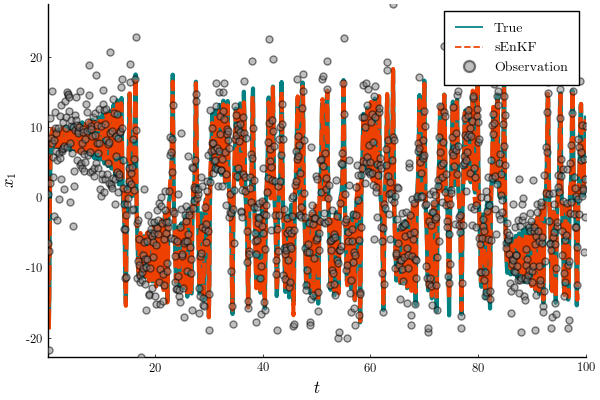

In [18]:
# Plot the first component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", ylabel = L"x_1")
plot!(plt, data.tt[nb:Δ:ne], data.xt[1,nb:Δ:ne], linewidth =  3, color = :teal, label = "True")
plot!(plt, data.tt[nb:Δ:ne], mean_hist(Xsenkf)[1,1+nb:Δ:1+ne], linewidth = 3, grid = false,
     color = :orangered2, linestyle = :dash, label = "sEnKF")
scatter!(plt, data.tt[nb:Δ:ne], data.yt[1,nb:Δ:ne], linewidth = 3, color = :grey, markersize = 5, alpha = 0.5, label = "Observation")
plt

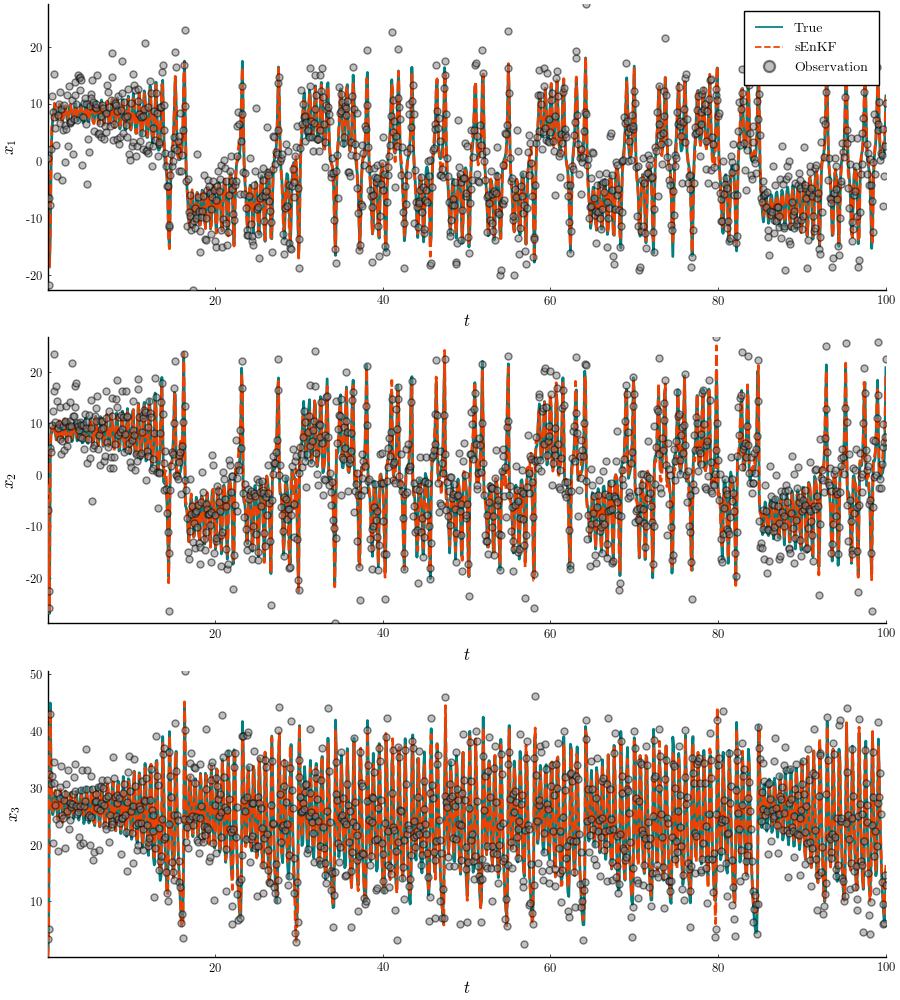

In [19]:
# Plot the different component of the state over time
nb = 1
ne = size(Xsenkf,1)-1
Δ = 1
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (900, 1000))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  2, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = (i == 1), label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(Xsenkf)[i,1+nb:Δ:1+ne], linewidth = 2, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
end

plt